# XG model - Statsbomb style
We want to build a xG model starting from the Statsbomb data on 16 years of data of La Liga.

In [54]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mplsoccer.pitch import Pitch
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as cbar

from sklearn.metrics import log_loss

pd.set_option('display.max_columns', 200)
pd.set_option('mode.chained_assignment', None)

In [2]:
data_path = '/Users/mfelici/personal_projects/football/data/statsbomb/open-data/data/'

#### Load competitions

In [3]:
competitions = pd.read_json(os.path.join(data_path, 'competitions.json'))
competitions = competitions.loc[competitions['competition_name'] == 'La Liga']

print(competitions.shape)
competitions

(16, 8)


,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
18,11,42,Spain,La Liga,male,2019/2020,2020-12-18T12:10:38.985394,2020-12-18T12:10:38.985394
19,11,4,Spain,La Liga,male,2018/2019,2020-07-29T05:00,2020-07-29T05:00
20,11,1,Spain,La Liga,male,2017/2018,2020-07-29T05:00,2020-07-29T05:00
21,11,2,Spain,La Liga,male,2016/2017,2021-02-02T23:24:58.985975,2021-02-02T23:24:58.985975
22,11,27,Spain,La Liga,male,2015/2016,2020-07-29T05:00,2020-07-29T05:00
23,11,26,Spain,La Liga,male,2014/2015,2020-07-29T05:00,2020-07-29T05:00
24,11,25,Spain,La Liga,male,2013/2014,2020-07-29T05:00,2020-07-29T05:00
25,11,24,Spain,La Liga,male,2012/2013,2020-07-29T05:00,2020-07-29T05:00
26,11,23,Spain,La Liga,male,2011/2012,2020-07-29T05:00,2020-07-29T05:00
27,11,22,Spain,La Liga,male,2010/2011,2020-07-29T05:00,2020-07-29T05:00


#### Load matches

In [4]:
match_dfs = []
for file in os.listdir(os.path.join(data_path, 'matches/11')):
    with open(os.path.join(data_path, 'matches/11', file), 'r') as f:
        match_dfs.append(pd.json_normalize(json.load(f)))

matches = pd.concat(match_dfs, 0).reset_index(drop=True)

del match_dfs
print(matches.shape)
matches.head()

(485, 40)


,match_id,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name
0,69225,2008-12-13,22:00:00.000,2,0,available,2020-07-29T05:00,15,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",220,Real Madrid,male,None,214,Spain,"[{'id': 3899, 'name': 'Juan de la Cruz Ramos C...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1011.0,Luis Medina Cantalejo,214.0,Spain
1,69212,2008-10-04,22:00:00.000,6,1,available,2020-07-29T05:00,6,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",212,Atlético Madrid,male,None,214,Spain,"[{'id': 3196, 'name': 'Javier Aguirre Onaindía...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1070.0,Iturralde,NaN,NaN
2,69235,2008-11-01,20:00:00.000,1,4,available,2020-07-29T05:00,9,11,Spain,La Liga,41,2008/2009,223,Málaga,male,None,214,Spain,"[{'id': 4989, 'name': 'Antonio Tapia Flores', ...",217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",1.1.0,2,2,1,Regular Season,346.0,Estadio La Rosaleda,214.0,Spain,407.0,Carlos Velasco Carballo,214.0,Spain
3,69232,2008-10-25,22:00:00.000,5,0,available,2020-07-29T05:00,8,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,NaN,403,Almería,male,None,214,Spain,NaN,1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1007.0,Alfonso Perez Burrull,NaN,NaN
4,69216,2009-03-07,20:00:00.000,2,0,available,2020-07-29T05:00,26,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",215,Athletic Bilbao,male,None,214,Spain,"[{'id': 497, 'name': 'Joaquín de Jesús Caparró...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,221.0,Alberto Undiano,112.0,Italy


## Load events
We look only after shots features

In [8]:
with open(os.path.join(data_path, 'events/303421.json'), 'r') as f:
    df = pd.json_normalize(json.load(f))

print(df.shape)
df.head()

(3979, 112)


,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,off_camera,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.body_part.id,pass.body_part.name,pass.type.id,pass.type.name,carry.end_location,under_pressure,dribble.outcome.id,dribble.outcome.name,dribble.nutmeg,duel.type.id,duel.type.name,duel.outcome.id,duel.outcome.name,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,counterpress,ball_recovery.recovery_failure,pass.assisted_shot_id,pass.shot_assist,shot.statsbomb_xg,shot.end_location,shot.key_pass_id,shot.technique.id,shot.technique.name,shot.body_part.id,shot.body_part.name,shot.type.id,shot.type.name,shot.outcome.id,shot.outcome.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.position.id,goalkeeper.position.name,goalkeeper.type.id,goalkeeper.type.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.aerial_won,pass.deflected,block.deflection,pass.switch,clearance.right_foot,foul_won.defensive,interception.outcome.id,interception.outcome.name,pass.cross,shot.first_time,out,pass.through_ball,pass.technique.id,pass.technique.name,shot.one_on_one,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.outcome.id,goalkeeper.outcome.name,goalkeeper.technique.id,goalkeeper.technique.name,pass.goal_assist,pass.no_touch,foul_committed.offensive,foul_committed.type.id,foul_committed.type.name,dribble.overrun,ball_recovery.offensive,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,clearance.left_foot,foul_committed.advantage,foul_won.advantage,injury_stoppage.in_chain,block.offensive,shot.redirect
0,99d03ac6-bd7b-452a-91be-32e28f96bc1c,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,206,Deportivo Alavés,1,Regular Play,206,Deportivo Alavés,442.0,"[{'player': {'id': 6571, 'name': 'Roberto Jimé...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45e9a850-9a07-4266-8c05-66565e7ac83c,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,206,Deportivo Alavés,1,Regular Play,217,Barcelona,433.0,"[{'player': {'id': 6590, 'name': 'Norberto Mur...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,715a7900-5e3a-41f6-9870-44dc657ba2bc,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,206,Deportivo Alavés,1,Regular Play,217,Barcelona,NaN,NaN,[9df4334c-c6e4-4457-97f2-8948375695c7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9df4334c-c6e4-4457-97f2-8948375695c7,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,206,Deportivo Alavés,1,Regular Play,206,Deportivo Alavés,NaN,NaN,[715a7900-5e3a-41f6-9870-44dc657ba2bc],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [6]:
shots_dfs = []
tot = matches.shape[0]

for i, match_id in enumerate(matches['match_id'].unique()):
    
    file = os.path.join(data_path, f'events/{match_id}.json')
    
    print(match_id, '{} / {}'.format(i+1, tot)) 
    
    with open(file, 'r') as f:
        df = pd.json_normalize(json.load(f))
        
    # Retrieve shots
    tmp = df.loc[(df['type.name'] == 'Shot')]

    # Data prep
    tmp['match_id'] = match_id
    tmp['x_shot'] = tmp['location'].apply(lambda x: x[0])
    tmp['y_shot'] = tmp['location'].apply(lambda x: x[1])
    tmp['x_shot_end'] = tmp['shot.end_location'].apply(lambda x: x[0])
    tmp['y_shot_end'] = tmp['shot.end_location'].apply(lambda x: x[1])
    tmp['z_shot_end'] = tmp['shot.end_location'].apply(lambda x: np.nan if len(x) <= 3 else x[2])


    tmp.rename(columns={'shot.body_part.name': 'body_part', 'shot.technique.name': 'technique',
                        'shot.outcome.name': 'outcome', 'shot.type.name': 'shot_type',
                        'shot.statsbomb_xg': 'xg', 'team.id': 'team_id',
                        'play_pattern.name': 'play_pattern', 'position.name': 'player_role',
                        'shot.freeze_frame': 'freeze_frame', 'shot.key_pass_id': 'key_pass'}, inplace=True)
    tmp = tmp[['id', 'match_id', 'team_id', 'x_shot', 'y_shot', 'x_shot_end', 'y_shot_end', 'body_part',
               'technique', 'outcome', 'shot_type', 'play_pattern', 'player_role', 'freeze_frame',
               'key_pass', 'xg']]
    
    passes = df.loc[(df['type.name'] == 'Pass'), ['id', 'pass.height.name', 'pass.end_location', 'minute', 'second']]
    passes.rename(columns={'pass.height.name': 'pass_height', 'minute': 'pass_minute',
                           'second': 'pass_second', 'id': 'key_pass'}, inplace=True)
    passes['x_pass_received'] = passes['pass.end_location'].apply(lambda x: x[0])
    passes['y_pass_received'] = passes['pass.end_location'].apply(lambda x: x[1])
    passes.drop(['pass.end_location'], 1, inplace=True)
    
    tmp = tmp.merge(passes, how='left', on='key_pass')

    shots_dfs.append(tmp)
    
# Put all together
shots = pd.concat(shots_dfs, 0).reset_index(drop=True)

69225 1 / 485
69212 2 / 485
69235 3 / 485
69232 4 / 485
69216 5 / 485
69209 6 / 485
69231 7 / 485
69217 8 / 485
69273 9 / 485
69223 10 / 485
69222 11 / 485
69195 12 / 485
69251 13 / 485
69185 14 / 485
69142 15 / 485
69139 16 / 485
69189 17 / 485
69171 18 / 485
69249 19 / 485
69215 20 / 485
69138 21 / 485
69147 22 / 485
69149 23 / 485
69177 24 / 485
69207 25 / 485
69228 26 / 485
69183 27 / 485
69279 28 / 485
69285 29 / 485
69230 30 / 485
69211 31 / 485
69144 32 / 485
69151 33 / 485
69169 34 / 485
68360 35 / 485
69186 36 / 485
69180 37 / 485
69143 38 / 485
69181 39 / 485
68365 40 / 485
69178 41 / 485
68364 42 / 485
69170 43 / 485
68359 44 / 485
68356 45 / 485
69158 46 / 485
69187 47 / 485
68363 48 / 485
69166 49 / 485
68366 50 / 485
69148 51 / 485
69145 52 / 485
69184 53 / 485
69173 54 / 485
69146 55 / 485
69182 56 / 485
68358 57 / 485
68361 58 / 485
69141 59 / 485
68314 60 / 485
68313 61 / 485
68316 62 / 485
68315 63 / 485
69153 64 / 485
68352 65 / 485
68353 66 / 485
69243 67 / 485
6924

In [57]:
# Let's create the output variable "goal"
shots['goal'] = 0
shots.loc[shots['outcome'] == 'Goal', 'goal'] = 1

print(shots.shape)
shots.head()

(12003, 22)


,id,match_id,team_id,x_shot,y_shot,x_shot_end,y_shot_end,body_part,technique,outcome,shot_type,play_pattern,player_role,freeze_frame,key_pass,xg,pass_height,pass_minute,pass_second,x_pass_received,y_pass_received,goal
0,d0a3a318-9e65-4f79-9a78-1e65d4ea5b82,69225,217,83.5,29.2,120.0,33.4,Left Foot,Half Volley,Off T,Open Play,From Free Kick,Left Back,"[{'location': [79.7, 38.1], 'player': {'id': 3...",NaN,0.010060,NaN,NaN,NaN,NaN,NaN,0
1,572ebe7b-7efb-4370-98d4-3d178ce0c59d,69225,217,110.4,54.2,118.2,41.8,Right Foot,Normal,Saved,Open Play,From Free Kick,Right Wing,"[{'location': [107.7, 43.2], 'player': {'id': ...",abff0790-4651-4fa7-b9b7-0c944ef79595,0.062470,Ground Pass,5.0,15.0,94.3,76.6,0
2,9f17a2a7-976c-4eb7-b4be-7cb6f2b9bdc1,69225,217,93.2,24.1,120.0,34.5,Right Foot,Normal,Off T,Open Play,From Throw In,Left Wing,"[{'location': [96.4, 37.6], 'player': {'id': 2...",15bb4d8f-54dd-4761-bbbe-06e2b09c116f,0.012832,Ground Pass,6.0,27.0,89.4,18.0,0
3,bb3d8291-0dba-40a9-9ed0-f395eef891f6,69225,217,108.1,53.1,118.8,41.6,Left Foot,Normal,Saved,Open Play,Regular Play,Right Wing,"[{'location': [108.2, 39.1], 'player': {'id': ...",1b9c7d76-5533-4ee3-8ac5-a60ac42e4827,0.043368,High Pass,15.0,52.0,103.9,35.9,0
4,71faa4ab-6734-4fa1-b309-29df1020285c,69225,217,100.7,36.6,104.8,36.6,Left Foot,Normal,Blocked,Open Play,From Counter,Center Defensive Midfield,"[{'location': [102.5, 20.3], 'player': {'id': ...",b92e0828-a0e6-485d-9421-0f42ce1db8f9,0.144784,Ground Pass,16.0,20.0,54.1,41.5,0


In [58]:
# Save results
shots.to_feather('shots_laliga')

In [10]:
# Reload results
shots = pd.read_feather('shots_laliga')

## Shots analysis
Let's analyse the Statsbomb xG model

In [11]:
shots.groupby('outcome').agg({'xg': 'mean'}).sort_values(by='xg', ascending=False)

,xg
outcome,
Goal,0.322634
Saved to Post,0.148298
Post,0.142459
Saved,0.118771
Wayward,0.093735
Off T,0.088760
Blocked,0.065273
Saved Off Target,0.050205


Only goals

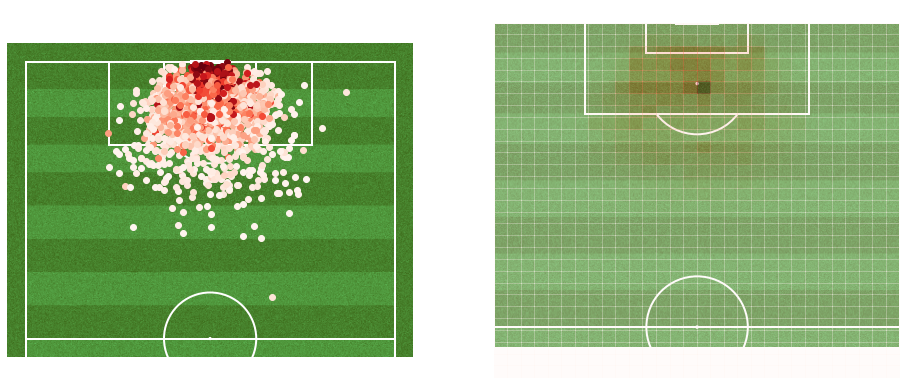

In [29]:
# Let's take ony goals
goals = shots.loc[shots['outcome'] == 'Goal']

cmap = plt.cm.Reds

cNorm  = colors.Normalize(vmin=goals_df['xg'].min(), vmax=goals_df['xg'].max())

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))


pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8))
pitch.draw(ax=ax[0])

for i, row in goals.iterrows():
    colorVal = scalarMap.to_rgba(row['xg'])
    ax[0].scatter(row['y_shot'], row['x_shot'], color=colorVal)
ax[0].set_title('Only goals', color='w')


pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8))
pitch.draw(ax=ax[1])

ax[1].hist2d(shots['y_shot'], shots['x_shot'], cmap=cmap, alpha=0.3, bins=30, range=[[0, 80], [50, 120]])
ax[1].set_title('All shots', color='w')
    
cb1 = cbar.ColorbarBase(axc, cmap=cmap, norm=cNorm,orientation='vertical')
    
    
plt.show()

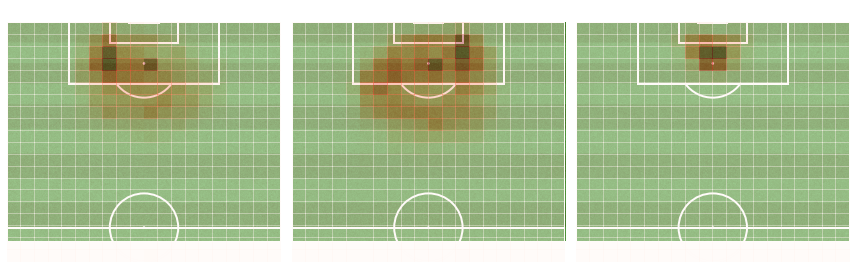

In [52]:
# Per body part

pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8), layout=(1, 3))
fig, ax = pitch.draw()


ax[0].hist2d(shots.loc[shots['body_part'] == 'Left Foot', 'y_shot'],
                shots.loc[shots['body_part'] == 'Left Foot', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[0].set_title('Left foot', color='white')


ax[1].hist2d(shots.loc[shots['body_part'] == 'Right Foot', 'y_shot'],
                shots.loc[shots['body_part'] == 'Right Foot', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[1].set_title('Right foot', color='white')


ax[2].hist2d(shots.loc[shots['body_part'].isin(['Head', 'Other']), 'y_shot'],
                shots.loc[shots['body_part'].isin(['Head', 'Other']), 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[2].set_title('Other', color='white')

plt.show()

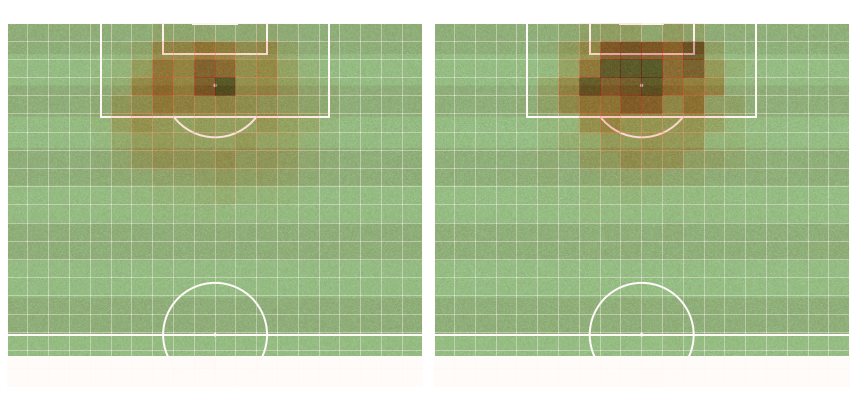

In [53]:
# Per technique

pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8), layout=(1, 2))
fig, ax = pitch.draw()


ax[0].hist2d(shots.loc[shots['technique'] == 'Normal', 'y_shot'],
                shots.loc[shots['technique'] == 'Normal', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[0].set_title('Normal', color='white')


ax[1].hist2d(shots.loc[shots['technique'] != 'Normal', 'y_shot'],
                shots.loc[shots['technique'] != 'Normal', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[1].set_title('Other', color='white')

plt.show()

What is the actual log-likelihood of the Statsbomb model on La Liga matches?

In [60]:
matches.head()

,match_id,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name
0,69225,2008-12-13,22:00:00.000,2,0,available,2020-07-29T05:00,15,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",220,Real Madrid,male,None,214,Spain,"[{'id': 3899, 'name': 'Juan de la Cruz Ramos C...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1011.0,Luis Medina Cantalejo,214.0,Spain
1,69212,2008-10-04,22:00:00.000,6,1,available,2020-07-29T05:00,6,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",212,Atlético Madrid,male,None,214,Spain,"[{'id': 3196, 'name': 'Javier Aguirre Onaindía...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1070.0,Iturralde,NaN,NaN
2,69235,2008-11-01,20:00:00.000,1,4,available,2020-07-29T05:00,9,11,Spain,La Liga,41,2008/2009,223,Málaga,male,None,214,Spain,"[{'id': 4989, 'name': 'Antonio Tapia Flores', ...",217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",1.1.0,2,2,1,Regular Season,346.0,Estadio La Rosaleda,214.0,Spain,407.0,Carlos Velasco Carballo,214.0,Spain
3,69232,2008-10-25,22:00:00.000,5,0,available,2020-07-29T05:00,8,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,NaN,403,Almería,male,None,214,Spain,NaN,1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1007.0,Alfonso Perez Burrull,NaN,NaN
4,69216,2009-03-07,20:00:00.000,2,0,available,2020-07-29T05:00,26,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",215,Athletic Bilbao,male,None,214,Spain,"[{'id': 497, 'name': 'Joaquín de Jesús Caparró...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,221.0,Alberto Undiano,112.0,Italy


In [63]:
# Minus because the sklearn functions returns the NEGATIVE log-likelihood
print(-log_loss(shots['goal'], shots['xg']))

# Does it change between seasons?
seasons = pd.merge(shots[['goal', 'xg', 'match_id']], matches[['match_id', 'season.season_name']], on='match_id')
display(seasons.groupby('season.season_name').apply(lambda x: -log_loss(x['goal'], x['xg'])))

-0.304162475333599


season.season_name
2004/2005   -0.354351
2005/2006   -0.253814
2006/2007   -0.268763
2007/2008   -0.264782
2008/2009   -0.337475
2009/2010   -0.305010
2010/2011   -0.293757
2011/2012   -0.322200
2012/2013   -0.369748
2013/2014   -0.287380
2014/2015   -0.299566
2015/2016   -0.298539
2016/2017   -0.338989
2017/2018   -0.268196
2018/2019   -0.298688
2019/2020   -0.326459
dtype: float64